In [2]:
import numpy as np
import cv2

def calculate_displacement(image_before, image_after, window_size=15):
    # 使用互相关法计算位移场
    # 在每个像素位置上，以窗口大小为基准，在加载前后的图像上寻找最佳匹配点
    # 这里使用OpenCV的matchTemplate函数来实现互相关计算

    # 根据窗口大小计算半窗口尺寸
    half_window = window_size // 2

    # 在加载前的图像上找到最佳匹配点的位置
    match_location = np.zeros_like(image_before, dtype=np.float32)
    match_location[half_window:-half_window, half_window:-half_window] = cv2.matchTemplate(image_before, image_after, cv2.TM_CCORR_NORMED)[half_window:-half_window, half_window:-half_window]

    # 计算位移场
    displacement_field = np.zeros_like(image_before, dtype=np.float32)
    for y in range(half_window, image_before.shape[0] - half_window):
        for x in range(half_window, image_before.shape[1] - half_window):
            # 找到最大匹配点的位置
            match_pos = np.unravel_index(np.argmax(match_location[y - half_window: y + half_window + 1, x - half_window: x + half_window + 1]), (window_size, window_size))

            # 计算位移向量
            displacement_field[y, x] = match_pos[0] - half_window, match_pos[1] - half_window

    return displacement_field

def calculate_strain(displacement_field):
    # 根据位移场计算形变场
    # 这里简单地假设形变场为二维平面的位移向量
    strain_field = np.gradient(displacement_field)

    return strain_field

# 读取加载前后的图片
image_before = cv2.imread("./database/c_data/bolt4/DSC02286.JPG", cv2.IMREAD_GRAYSCALE)
image_after = cv2.imread("./database/c_data/bolt4/DSC02300.JPG", cv2.IMREAD_GRAYSCALE)

# 计算位移场
displacement_field = calculate_displacement(image_before, image_after)

# 计算形变场
strain_field = calculate_strain(displacement_field)

# 输出形变场和应变场
print(strain_field)

ValueError: could not broadcast input array from shape (0,0) into shape (1186,1186)

In [26]:
import pandas as pd
import numpy as np

# 读取CSV文件
df = pd.read_csv('label/AI-bolt-color-202404-inkan.csv')

#file = np.array(df)
print(df.iloc[0]['load']-10)

10.322


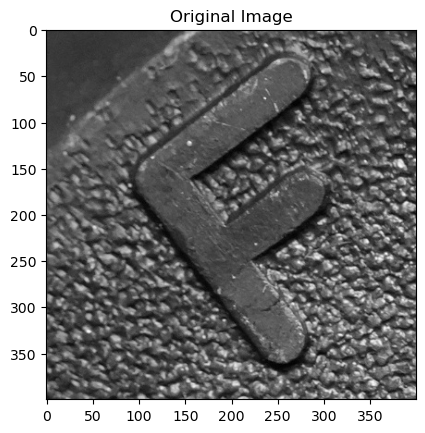

[-0.02227598  1.3078264   0.3646663   0.2843794   0.7753029   2.8341064
 -1.1443939   0.58761597]


In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift

# Load the image
image_path = 'database/202404-inkan/output-resize/DSC02098.JPG'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
diffimage = cv2.imread('database/202404-inkan/output-resize/DSC02158.JPG', cv2.IMREAD_GRAYSCALE)

cropimage1 = image[300:700, 450:850] #(y:y,x:x)
cropimage2 = diffimage[300:700, 450:850] #(y:y,x:x)
  

# Display the original image
plt.imshow(cropimage1, cmap='gray')
plt.title('Original Image')
plt.show()

# def diffimg(img0,img1):
#   # 将图像转换为灰度图
#   #gray_image1 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
#   #gray_image2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#   # 计算两个图像的差异
#   diff = cv2.absdiff(img0, img1)
#   # 设置一个阈值，将差异值大于阈值的像素设为白色
#   _, threshold = cv2.threshold(diff, 10, 255, cv2.THRESH_BINARY)
#   # 找到白色区域的轮廓
#   contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#   # 创建空白图像
#   diffimg = np.zeros_like(img0)
#   cv2.drawContours(diffimg, contours, -1, (0, 255, 0), 2)
#   return diffimg

# diffimg = diffimg(cropimage1,cropimage2)
# plt.imshow(diffimg)

def opticalflow(img0,img1):
    # Shi-Tomasi角点检测参数
    feature_params = dict(maxCorners=1000, qualityLevel=0.1, minDistance=10, blockSize=2)
    # lucas kanade光流参数
    lk_params = dict(winSize=(5, 5), maxLevel=1, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.02))
    # 寻找初始关键点
    p0 = cv2.goodFeaturesToTrack(img0, mask=None, **feature_params)
    # 计算光流
    p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
    # 选择好的点
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    # 绘制轨迹
    #mask = np.zeros_like(img0)

    # 计算光流矢量
    flow_vectors = good_new - good_old  # shape: (N, 2)

    # 提取特征
    mean_flow = np.mean(flow_vectors, axis=0)
    std_flow = np.std(flow_vectors, axis=0)
    max_flow = np.max(flow_vectors, axis=0)
    min_flow = np.min(flow_vectors, axis=0)

    features = np.hstack((mean_flow, std_flow, max_flow, min_flow))

    return features

opticalflowimg = opticalflow(cropimage1,cropimage2)

# # 可视化结果
# plt.imshow(cv2.cvtColor(opticalflowimg, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()
print(opticalflowimg)

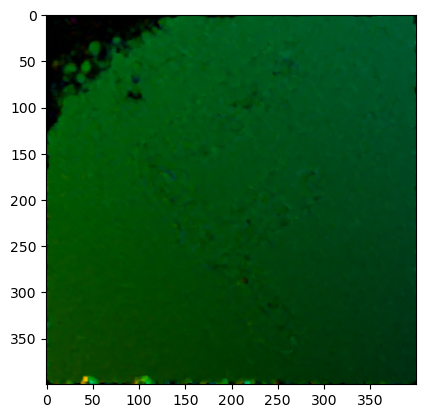

In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_optical_flow_farneback(img0, img1):
    # 将图像转换为灰度图
    img0_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    # 使用Farneback方法计算光流
    flow = cv2.calcOpticalFlowFarneback(
        img0_gray, img1_gray, None, 
        pyr_scale=0.5,  # 图像金字塔每层的缩放比例
        levels=3,       # 金字塔层数
        winsize=5,     # 平均窗口大小
        iterations=3,   # 每层的迭代次数
        poly_n=7,       # 每个像素点的邻域大小
        poly_sigma=1.1, # 高斯标准差
        flags=0         # 操作标志
    )
    # 可视化光流场
    hsv = np.zeros_like(img0)
    hsv[..., 1] = 255
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return bgr

# 示例使用
img0 = cv2.imread('database/202404-inkan/output-resize/DSC02098.JPG')
img1 = cv2.imread('database/202404-inkan/output-resize/DSC02416.JPG')
cropimage1 = img0[300:700, 450:850] #(y:y,x:x)
cropimage2 = img1[300:700, 450:850] #(y:y,x:x)

result = calculate_optical_flow_farneback(cropimage1, cropimage2)

# 使用matplotlib显示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()


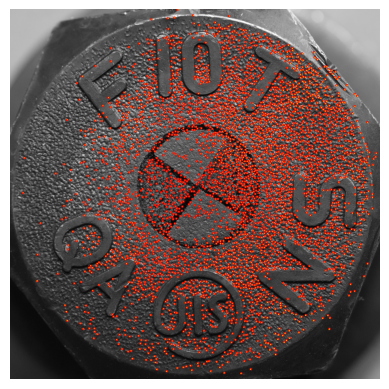

True

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_optical_flow_lk(img0, img1):
    # 转为灰度图
    img0_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    # Shi-Tomasi角点检测参数
    feature_params = dict(maxCorners=5000, qualityLevel=0.1, minDistance=10, blockSize=2)
    
    # Lucas-Kanade光流参数
    lk_params = dict(winSize=(5, 5), maxLevel=1, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.02))
    
    # 寻找初始关键点
    p0 = cv2.goodFeaturesToTrack(img0_gray, mask=None, **feature_params)
    
    # 计算光流
    p1, st, err = cv2.calcOpticalFlowPyrLK(img0_gray, img1_gray, p0, None, **lk_params)
    
    # 选择好的点
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    
    # 创建用于绘制光流的遮罩
    mask = np.zeros_like(img0)
    
    # 绘制光流
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel().astype(int)
        c, d = old.ravel().astype(int)
        mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
        img1 = cv2.circle(img1, (a, b), 5, (0, 0, 255), -1)
    
    # 将光流叠加在图像上
    img = cv2.add(img1, mask)
    return img

# 示例使用
img0 = cv2.imread('database/202404-inkan/output-resize/DSC02098.JPG')
img1 = cv2.imread('database/202404-inkan/output-resize/DSC02258.JPG')
#cropimage1 = img0[300:700, 450:850] #(y:y,x:x)
#cropimage2 = img1[300:700, 450:850] #(y:y,x:x)

cropimage1 = img0[150:1750, 250:1850] #(y:y,x:x)
cropimage2 = img1[150:1750, 250:1850] #(y:y,x:x)

result = calculate_optical_flow_lk(cropimage1, cropimage2)

# 使用matplotlib显示结果
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# 保存图像用于AI模型
cv2.imwrite('optical_flow_result.jpg', result)
